<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/main/evidence_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evidence Network example

In [1]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 121.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 73.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalle

In [2]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[]
[0]
2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Import Data and Save as Numpy file 
Once Numpy file is created it is not necessary to run this

In [ ]:
# import and save data as npy file
train_Illu = np.loadtxt(path+"/galaxies_IllustrisTNG_z=0.00.txt", float)
train_SIMB = np.loadtxt(path+"/galaxies_SIMBA_z=0.00.txt", float)

f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()

np.save(path+'/gal_Illu.npy',train_Illu)
np.save(path+'/gal_SIMB.npy',train_SIMB)


In [ ]:
f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()
header = header.split('|')
print(header[0:10])
# gal_Illu

## Load and prepare data
Each data file contains >100,000 data vectors. Note that SIMBA is about a 1.6x larger dataset than IllustrisTNG. A data vector is a package of 17 properties for a given galaxy. The values are normalised as they range over several orders of magnitude. A dataframe for each model is made to examine the data, but the numpy array is fed into the network as this is faster. <br>
The models are assigned the labels; SIMBA (1), IllustrisTNG (0). They are combined into one set of training data. x_train is the data and y_train is the labels. 


In [4]:
# unpack data
train_Illu = np.load(path+'/gal_Illu.npy')
train_SIMB = np.load(path+'/gal_SIMB.npy')
print(np.shape(train_Illu))

# get headers and convert to pandas 
header = 'gas mass | stellar mass | black-hole mass | total mass | Vmax | velocity dispersion | gas metallicity | stars metallicity | star-formation rate | spin | peculiar velocity | stellar radius | total radius | Vmax radius | U | K | g'
header = header.split('|')

df_Illu = pd.DataFrame(train_Illu, columns=header)
df_SIMB = pd.DataFrame(train_SIMB, columns=header)

# add model labels 'm'
df_Illu['m'] = np.zeros(df_Illu.shape[0])
df_SIMB['m'] = np.ones(df_SIMB.shape[0])



(720548, 17)


In [5]:
df_gal = df_Illu.append(df_SIMB)
df_gal.head()
# df_gal.iloc[0:5,0:5]

<ipython-input-5-bbc7c8626d90>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gal = df_Illu.append(df_SIMB)


,gas mass,stellar mass,black-hole mass,total mass,Vmax,velocity dispersion,gas metallicity,stars metallicity,star-formation rate,spin,peculiar velocity,stellar radius,total radius,Vmax radius,U,K,g,m
0,9.282650e+12,5.420345e+11,1.466206e+09,6.418189e+13,728.5484,388.82180,0.004787,0.017947,9.441491,7318.4480,33.48256,0.021288,0.265175,0.195745,-22.93387,-26.54785,-23.42693,0.0
1,1.038497e+11,2.636133e+10,1.044907e+07,9.836553e+11,233.9234,119.81900,0.018286,0.015760,2.637218,1866.9370,514.23650,0.005122,0.044712,0.015302,-21.15315,-23.88854,-21.25109,0.0
2,9.195971e+08,2.106634e+10,1.157354e+08,3.509456e+11,208.0617,99.18353,0.009185,0.015279,0.000000,129.6710,469.85760,0.003984,0.025255,0.004423,-19.08513,-23.24341,-19.95050,0.0
3,3.779673e+10,1.197717e+09,1.650660e+06,2.944225e+11,155.9398,88.05768,0.002823,0.003315,0.186221,1364.7460,903.87620,0.007515,0.026186,0.027755,-18.45237,-20.64906,-18.61216,0.0
4,6.460591e+09,9.020908e+09,3.054039e+06,1.818515e+11,150.3801,76.50587,0.016340,0.010027,0.260545,115.4676,318.39040,0.005950,0.019798,0.007311,-19.32953,-22.77941,-19.95593,0.0


In [6]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
train_Illu = np.append(train_Illu, np.zeros((len(train_Illu[:,0]),1)) ,axis=1)
train_SIMB = np.append(train_SIMB, np.ones((len(train_SIMB[:,0]),1)) ,axis=1)



In [7]:
# combine into one dataset
train_data = np.append(train_SIMB,train_Illu, axis=0 )
train_data = train_data[:,[1,7,-1]]
# print(train_Illu.shape)
# print(train_SIMB.shape)
print(train_data[:,:-1].shape)


(1902813, 2)


In [8]:
train_data

array([[4.807714e+11, 1.858564e-02, 1.000000e+00],
       [2.389855e+09, 1.399460e-03, 1.000000e+00],
       [4.058050e+08, 4.641813e-04, 1.000000e+00],
       ...,
       [3.211801e+08, 3.859784e-03, 0.000000e+00],
       [2.330075e+08, 2.981702e-03, 0.000000e+00],
       [2.380963e+08, 3.564553e-03, 0.000000e+00]])

In the following we select a sub-sample of the data to speed up training. The dataset is then split into training and testing in an 80:20 split. 


In [34]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_data.shape[0], 
                                  size=n_sample, 
                                  replace=False)
train_data = train_data[choices,:]
print(train_data.shape)


# separate training data and training labels into x and y
x_train, x_test, y_train, y_test = train_test_split(train_data[:,:-1], train_data[:,-1], test_size=0.20, shuffle=True, random_state=42)



(500000, 3)


In [35]:
x_train[:,1].min()

0.0001815357

In [36]:
# normalise training data 
x_train_scaled = np.copy(x_train)
x_train_scaled[:,0] = np.log(x_train_scaled[:,0])

x_test_scaled = np.copy(x_test)
x_test_scaled[:,0] = np.log(x_test_scaled[:,0])

scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5
x_test_scaled = scaler.transform(x_test_scaled)/20.+0.5


In [37]:
x_train_scaled[:,0].max()

0.7519178246833478

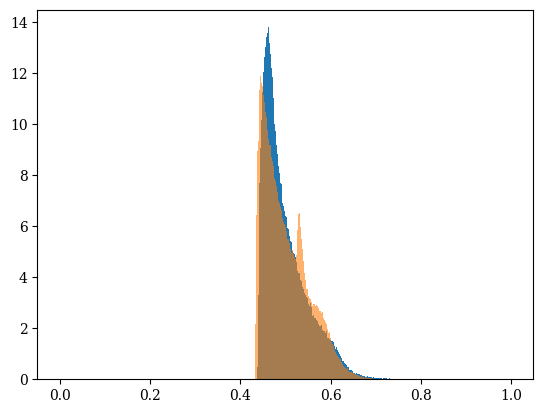

In [38]:
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(0,1,512),density=True)
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(0,1,512),alpha=0.6,density=True)


This cell finds the ratio of samples from each model. 

In [39]:
scale = np.sum(y_train)/np.sum(1 - y_train)

print('Current prior model ratio (model 1/model 0): ',
      scale,
      flush=True)


# scale_rescale = 40.*np.std(y_train,axis=0)
# print(scale_rescale)

Current prior model ratio (model 1/model 0):  1.6360185575706454


## Define functions for network

In [40]:
#C just defined set of mathematical functions 

def smooth_sign(x, k =100.):
    
    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [41]:
# Evidence Net functions:
    
class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)
    
    
class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag

        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
            
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
             
        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))

        
        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)
        
        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=2)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer) 
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric, 'accuracy'])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))
        

# Evidence Net

In [85]:
# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 10
n_models = 4 

#####
# n_test_calc = np.min([n_validation,20000])
# print(n_test_calc)
# n_test_calc = x_test_scaled.shape[0]

# validation_model = np.atleast_2d([training_model[-n_test_calc:], 1. -training_model[-n_test_calc:]]).T
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######

model_instances = []
model_instances_model = []
histories = []


with tf.device('/device:GPU:0'):
    
    for model_count in range(n_models):
        
        model_instances.append(DenseNetwork(N, weight_init='he_normal',
                                            layer_width=16, added_layers=1,
                                            learning_rate=1e-4, decay_rate=0.95,
                                            batch_norm_flag=1))


        model_instances_model.append(model_instances[-1].model())
                               
        # validation_prediction = (model_instances_model[-1].predict(x_test_scaled))
        # print('Initialization: mean =', validation_prediction.mean(), 'std= ', validation_prediction.std())
                                                   
        histories.append(model_instances_model[-1].fit(x_train_scaled,y_train,                 
            epochs=epochs, batch_size=100,
                             shuffle=True,
                             validation_data = (x_test_scaled, y_test),
                             verbose=1))
        
        gc.collect()

Hyper-parameters: 2 he_normal 16 1 0.0001 0.95 1 0
Epoch 1/10
4000/4000 [==============================] - 10s 2ms/step - loss: 0.8409 - lr: 9.7976e-05 - accuracy: 0.6551 - val_loss: 0.7989 - val_lr: 9.5979e-05 - val_accuracy: 0.7074
Epoch 2/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.8061 - lr: 9.4036e-05 - accuracy: 0.7022 - val_loss: 0.7936 - val_lr: 9.2120e-05 - val_accuracy: 0.7134
Epoch 3/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8036 - lr: 9.0256e-05 - accuracy: 0.7049 - val_loss: 0.7924 - val_lr: 8.8417e-05 - val_accuracy: 0.7147
Epoch 4/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8018 - lr: 8.6627e-05 - accuracy: 0.7085 - val_loss: 0.7948 - val_lr: 8.4862e-05 - val_accuracy: 0.7196
Epoch 5/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.8000 - lr: 8.3144e-05 - accuracy: 0.7101 - val_loss: 0.7889 - val_lr: 8.1450e-05 - val_accuracy: 0.7177
Epoch 6/10
4000/4000 [================

In [43]:
validation_prediction = (model_instances_model[-1].predict(x_test_scaled))
print(validation_prediction)

[[ 1.7910066 ]
 [ 1.3898292 ]
 [ 4.276488  ]
 ...
 [ 0.58622545]
 [ 0.85506296]
 [-0.59046996]]


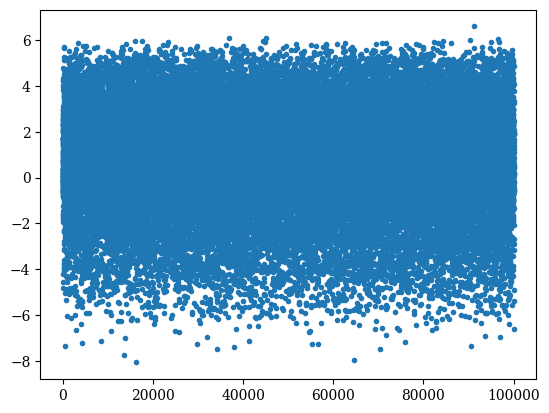

In [89]:
# plt.hist(validation_prediction,bins=200)
plt.plot(validation_prediction,'.')
# plt.ylim(-100,100)


# validation_prediction_mean = np.mean(validation_prediction)
# log_K_net = np.log10(np.exp(validation_prediction_mean))
# print(log_K)




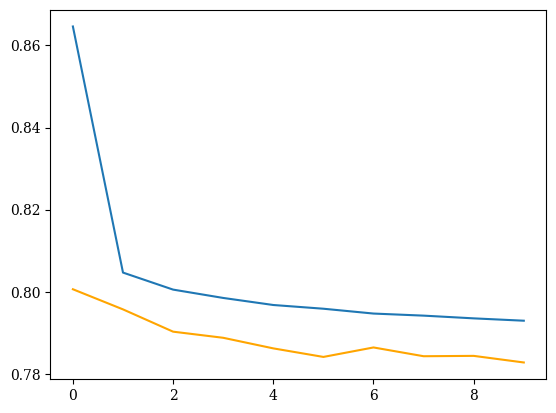

In [45]:
for i in range(n_models):
    _ = plt.plot(histories[i].history['loss'][:])
    _ = plt.plot(histories[i].history['val_loss'][:],'orange')

In [46]:
# validation_prediction_array = np.array([leaky_parity_odd_power(model_instances_model[i].predict(1.-validation_data_rescaled), alpha=2) \
                          # for i in range(n_models)])
# validation_prediction = validation_prediction_array.mean(axis=0).flatten()

# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [60]:
# calculate posteriors from network log K values 
posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 20
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

(100000, 1)


In [75]:
# perform coverage test
bin_centres, fractions, post_bin_means, post_bin_n = [],[],[],[]

for i in range(0,len(probability_array)-1):
  # bin posteriors
  indexes = np.where((posterior_model_prob > probability_array[i]) 
                                      & (posterior_model_prob < probability_array[i+1]))[0]
  post_bin = posterior_model_prob[indexes]
  post_bin_mean = float(np.mean(posterior_model_prob[indexes]))
  post_bin_mid = float((probability_array[i]+probability_array[i+1]) / 2)
  post_bin_size = float(len(post_bin))

  # get fraction of model 1 labels in each bin
  label_bin = y_test[indexes]
  fraction = np.sum(label_bin) / len(label_bin)

  bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_means.append(post_bin_mean), post_bin_n.append(post_bin_size)


# get the binomial error for each bin
binomial_std = np.sqrt((np.asarray(post_bin_means)*(1.-np.asarray(post_bin_means))) / np.asarray(post_bin_n))



In [86]:
binomial_std

array([0.0027938 , 0.00659601, 0.00952994, 0.01124537, 0.01260947,
       0.01112279, 0.00631388, 0.00593687, 0.00644338, 0.00571886,
       0.00611269, 0.00633218, 0.00610433, 0.00550071, 0.00555014,
       0.00473045, 0.00379463, 0.0027443 , 0.00175919])

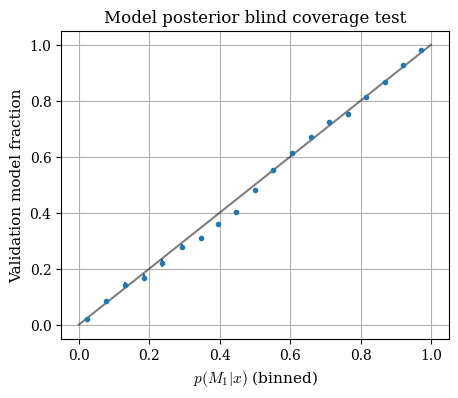

In [77]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(post_bin_means, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

In [70]:
binomial_std

array([0.0027938 , 0.00659601, 0.00952994, 0.01124537, 0.01260947,
       0.01112279, 0.00631388, 0.00593687, 0.00644338, 0.00571886,
       0.00611269, 0.00633218, 0.00610433, 0.00550071, 0.00555014,
       0.00473045, 0.00379463, 0.0027443 , 0.00175919])

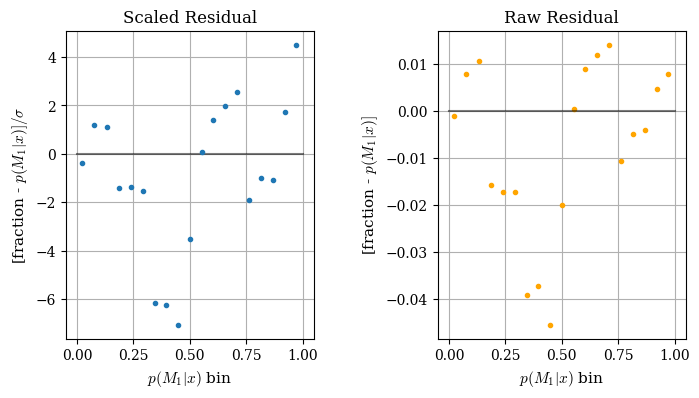

In [92]:
residual = (np.asarray(fractions) - np.asarray(post_bin_means))/np.asarray(binomial_std)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(post_bin_means, residual,yerr=binomial_std, marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)
